# **Validation without resampled strategy**
To evaluate the generalizability and robustness of our QSAR classification models, we conducted an additional validation using the original, imbalanced dataset without resampling strategies. 
This experiment preserves the inherent class imbalance by training on the full set of negative samples and a fixed set of positives.


### **Key characteristics of this experiment include:**

* **No sub-sampling of the negative candidate pool.**
* Full negative set (**n = 6677**) combined with the same positive training set (n = 508).
* Identical test set (n = 438; balanced) as used in the main experiments for fair comparison.
* Feature selection and modeling follow exactly the same pipeline of the resampled workflow.

This setup allows us to quantify the performance gap between balanced and imbalanced training schemes and to validate the stability of our feature selection and classification models in more realistic, skewed settings.

## **Step1: Data Preprocessing**

1. Load the identical data
2. Split Train/test
3. Filtered by low variance


In [2]:
### Data loading & processing ###
import pandas as pd
import os
from tqdm import tqdm

positive = pd.read_csv("antioxi_des_776.csv", index_col='Name')                                                                        # n =776
negative = pd.read_csv("negative_des_8443.csv", index_col = "Name")                                                                    # n = 8443

neg_df_dup = negative.drop_duplicates(keep = 'first')                                                                                  # n = 8369
pos_df_dup = positive.drop_duplicates(keep='first')                                                                                    # n = 751
pos_df, neg_df = pos_df_dup.dropna(), neg_df_dup.dropna()                                                                
pos_df, neg_df = (pos_df.assign(y_true=1), neg_df.assign(y_true=0))                                                                    # n = 727, 6677       

#neg_df.to_csv("negative_des_dupna_6677.csv", index=True)
#pos_df.to_csv("antioxidant_des_dupna_727.csv", index=True)

In [3]:
### train : test = 7: 3 split (pos) ###
from sklearn.model_selection import train_test_split

# Load the preprocessed positive and negative descriptor datasets
# neg_df = pd.read_csv("negative_des_dupna_6677.csv", index_col='Name')
# pos_df = pd.read_csv("antioxidant_des_dupna_727.csv", index_col='Name')

# Split the positive set into 70% training and 30% test sets
train_pos, test_pos = train_test_split(pos_df, test_size=0.3, random_state=1004)                                                      # train_pos = 508, test_pos = 219

# Randomly sample an equal number of negatives to match the positive test set (219 samples)
test_neg = neg_df.sample(n=len(test_pos), random_state=1004)                                                                          # test_neg = 219
test_set = pd.concat([test_pos, test_neg])                                                                                            # test_set = 438

# Exclude selected negative test samples from the negative pool to define the negative training set
train_total_neg = neg_df.drop(test_neg.index)                                                                                         # train_neg = 6458 
#train_total_neg.to_csv("./train/train_total_neg_6458.csv", index=True) 

In [5]:
from sklearn.feature_selection import VarianceThreshold
# Save the resulting datasets to CSV files
os.makedirs("./figure_total_neg", exist_ok=True)

# Concatenate train_pos and train_total_neg vertically
train_total_data = pd.concat([train_pos, train_total_neg], axis=0)

# Exclude the target variable column 'y_true' from features
X_train_total_data = train_total_data.drop(columns=['y_true'])
y_train_total_data = train_total_data['y_true']

# 1. Remove low variance features
# VarianceThreshold removes features whose variance is below the specified threshold.
threshold = 0.05  # For example, remove features with less than 5% variance
selector = VarianceThreshold(threshold=threshold)
X_low_variance_removed = selector.fit_transform(X_train_total_data)

# Get the names of selected features
selected_features = X_train_total_data.columns[selector.get_support()]
print("Number of features remaining after removing low-variance features:", len(selected_features))

# Create a new DataFrame with selected features
train_data_selected = pd.DataFrame(X_low_variance_removed, columns=selected_features)
train_data_selected['y_true'] = y_train_total_data.reset_index(drop=True)

# Separate positive and negative samples based on y_true
train_pos_selected = train_data_selected[train_data_selected['y_true'] == 1].copy()
train_neg_selected = train_data_selected[train_data_selected['y_true'] == 0].copy()

# Restore original index from train_pos and train_total_neg
train_pos_selected.index = train_pos.index
train_neg_selected.index = train_total_neg.index

# Print result
print("Positive sample shape:", train_pos_selected.shape)
print("Negative sample shape:", train_neg_selected.shape)

Low variance 제거 후 남은 feature 개수: 893
Positive sample shape: (508, 894)
Negative sample shape: (6458, 894)


## **Step2: Feature selection**


#### **1. RF-based Feature Importances**

In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
import pandas as pd
import numpy as np
from tqdm import tqdm

# Sample and prepare the dataset
dataset = train_data_selected.copy()
y = dataset["y_true"]
X = dataset.drop("y_true", axis=1)

n_runs = 50  # Number of runs per dataset for feature selection
initial_seed = 42
np.random.seed(initial_seed)
random_states = np.random.randint(0, 1000, size=n_runs)

feature_importances = np.zeros((n_runs, X.shape[1]))  # Initialize to zeros

# Train the Random Forest and collect feature importances
for run in tqdm(range(n_runs)):
    rf = RFC(n_estimators=100, random_state=random_states[run])
    rf.fit(X, y)
    feature_importances[run, :] = rf.feature_importances_

# Calculate mean importance for all runs
mean_importances = feature_importances.mean(axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:50<00:00, 20.21s/it]


#### **2. Automated Elbow Point Detection with KneeLocator**

First Elbow Point: 42
Second Elbow Point: 72


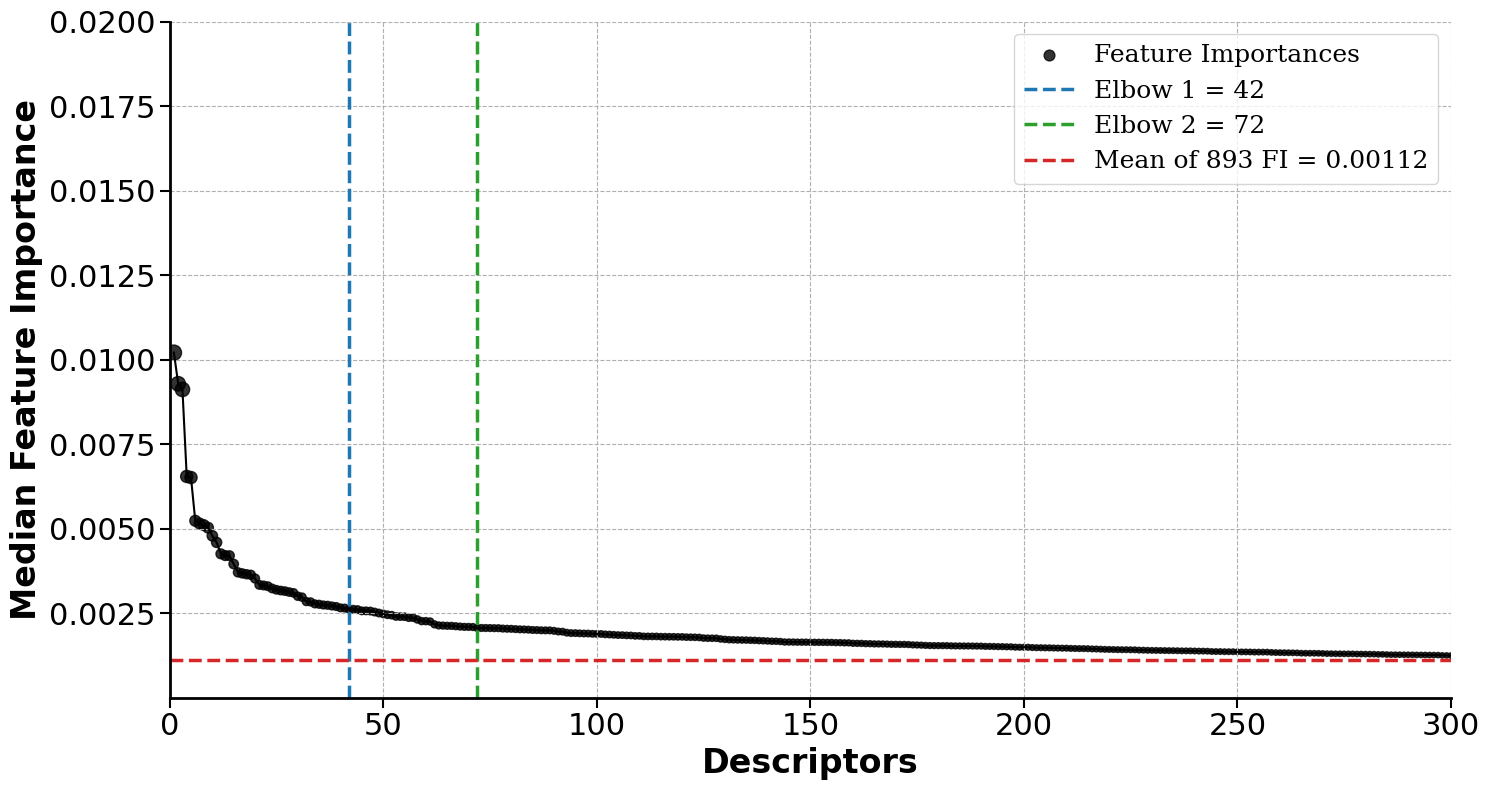

In [9]:
import matplotlib.pyplot as plt
# Create a DataFrame from the averaged feature importances
importances_df = pd.DataFrame(mean_importances, index=X.columns, columns=["Importance"])

# Sort features by descending importance
sorted_features = importances_df.sort_values(by="Importance", ascending=False)

from kneed import KneeLocator

# Define feature indices and corresponding importance values
feature_indices = np.arange(1, len(sorted_features) + 1)
sorted_importances = sorted_features["Importance"].values
mean_importance = sorted_importances.mean()

# Locate the first elbow point
kneedle_1 = KneeLocator(feature_indices, sorted_importances, curve='convex', direction='decreasing')
elbow_1 = kneedle_1.knee
print("First Elbow Point:", elbow_1)

# Attempt to identify a second elbow point beyond the first one
elbow_2 = None
if elbow_1 is not None:
    x2 = feature_indices[elbow_1:]
    y2 = sorted_importances[elbow_1:]
    
    kneedle_2 = KneeLocator(x2, y2, curve='convex', direction='decreasing')
    elbow_2 = kneedle_2.knee
    print("Second Elbow Point:", elbow_2)

# Normalize marker sizes based on importance scores
scaled_marker_size = (sorted_features / sorted_features.max()) * 120

# Plot settings
plt.figure(figsize=(15, 8))

# Plot importance trend line
plt.plot(feature_indices, sorted_features, color='black', linewidth=1.5)

# Set font style to Times New Roman
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# Scatter plot for each feature importance with scaled marker sizes
plt.scatter(feature_indices, sorted_features, 
            s=scaled_marker_size, color='black', alpha=0.8, label='Feature Importances')

# Draw vertical line for the first elbow point
if elbow_1 is not None:
    plt.axvline(x=elbow_1, color='tab:blue', linestyle='--', lw=2.5, label=f'Elbow 1 = {elbow_1}')

# Draw vertical line for the second elbow point, if exists
if elbow_2 is not None:
    plt.axvline(x=elbow_2, color='tab:green', linestyle='--', lw=2.5, label=f'Elbow 2 = {elbow_2}')

# Draw horizontal line for mean importance
plt.axhline(y=mean_importance, color='tab:red', linestyle='--', lw=2.5, label=f'Mean of 893 FI = {mean_importance:.5f}')

# Axis and style settings
plt.xlabel('Descriptors', fontsize=24, fontweight='bold')
plt.xlim(0, 300)
plt.ylabel('Median Feature Importance', fontsize=24, fontweight='bold')
plt.ylim(0, 0.02)
plt.yticks([tick for tick in plt.yticks()[0] if tick != 0])
plt.tick_params(axis='both', labelsize=22, width=1.5, length=7)

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# Retain only bottom and left ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Set thicker lines for bottom and left axes
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Add grid and legend
plt.grid(True, linestyle='--', linewidth='0.8')
plt.legend(fontsize=18, loc='best')

# Adjust layout for clarity and export option
plt.tight_layout()
# plt.savefig(save_path, dpi=300)
plt.show()


## **Step3: Model Training and Evaluation**

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

train_cls = train_data_selected.copy()
test_cls = test_set.copy()

# Define the figure path
figure_path = './figure_total_neg'

# Extract true class labels from training and test sets
Y_train_cls = train_cls["y_true"]
Y_test_cls = test_cls["y_true"]

### Select Descriptor Subsets (Top42, Top72) ###
# Select top 42 and top 72 features based on elbow point analysis
top_42_features = sorted_features.index[:42]
top_72_features = sorted_features.index[:72]

# Extract feature subsets from training data
X_top_42 = train_cls[top_42_features]
X_top_72 = train_cls[top_72_features]

# Define feature sets using the selected top descriptors
feature_sets = {
    "Top42": X_top_42.columns,
    "Top72": X_top_72.columns,
}

# Define model pipelines and corresponding hyperparameter grids for GridSearchCV
models = [
    ('Random Forest', Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=1004, bootstrap=True))
    ]), {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__min_samples_split': [2, 5],
        'rf__max_features': ['sqrt']
    }),

    ('SVM', Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=1004))
    ]), {
        'svm__kernel': ['linear', 'rbf'],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': ['scale', 0.01]
    }),

    ('XGBoost', Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(eval_metric='logloss', random_state=1004))
    ]), {
        'xgb__n_estimators': [100, 200],
        'xgb__max_depth': [3, 5],
        'xgb__learning_rate': [0.01, 0.1],
        'xgb__subsample': [0.7, 0.8],
        'xgb__colsample_bytree': [0.8],
        'xgb__min_child_weight': [1, 3],
        'xgb__reg_lambda': [1, 3]
    }),

    ('Logistic Regression', Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(random_state=1004, max_iter=3000))
    ]), {
        'lr__C': [0.01, 0.1, 1, 10]
    }),

    ('MLP', Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(random_state=1004))
    ]), {
        'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64, 32)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__solver': ['adam'], 
        'mlp__alpha': [0.0001, 0.001],
        'mlp__learning_rate': ['constant', 'adaptive'],
        'mlp__learning_rate_init': [0.001, 0.0005],
        'mlp__max_iter': [200, 300, 500],
        'mlp__early_stopping': [True]
    })
]

# Define stratified k-fold cross-validation to preserve class distribution
skfold = StratifiedKFold(n_splits=5, random_state=1004, shuffle=True)

# Dictionaries to store performance scores, best parameters, and best estimators
performance_scores = {}
best_params = {}
best_estimators_dict = {} 
test_roc_dict = {'Top51': [], 'Top79': []}

# Define custom scoring function for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Define evaluation metrics for GridSearchCV
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef),
    'specificity': make_scorer(specificity_score)
}

In [11]:
def evaluate_model_no_smooth(grid_search_model, model_name, X_train_cls, Y_train_cls, X_test_cls, Y_test_cls, figure_path):
    
    best_model = grid_search_model.best_estimator_

    # Predict and evaluate performance on the training set
    y_train_pred = best_model.predict(X_train_cls)
    y_train_proba = best_model.predict_proba(X_train_cls)[:, 1]
    train_acc = accuracy_score(Y_train_cls, y_train_pred)
    train_auc = roc_auc_score(Y_train_cls, y_train_proba)
    train_f1 = f1_score(Y_train_cls, y_train_pred)
    train_mcc = matthews_corrcoef(Y_train_cls, y_train_pred)
    train_spec = specificity_score(Y_train_cls, y_train_pred)

    # Predict and evaluate performance on the test set
    y_test_pred = best_model.predict(X_test_cls)
    y_test_proba = best_model.predict_proba(X_test_cls)[:, 1]
    test_acc = accuracy_score(Y_test_cls, y_test_pred)
    test_auc = roc_auc_score(Y_test_cls, y_test_proba)
    test_f1 = f1_score(Y_test_cls, y_test_pred)
    test_mcc = matthews_corrcoef(Y_test_cls, y_test_pred)
    test_spec = specificity_score(Y_test_cls, y_test_pred)

    # Retrieve cross-validation results
    cv_results = grid_search_model.cv_results_
    best_idx = grid_search_model.best_index_
    cv_acc, cv_std_acc = cv_results['mean_test_accuracy'][best_idx], cv_results['std_test_accuracy'][best_idx]
    cv_auc, cv_std_auc = cv_results['mean_test_roc_auc'][best_idx], cv_results['std_test_roc_auc'][best_idx]
    cv_f1,  cv_std_f1  = cv_results['mean_test_f1'][best_idx], cv_results['std_test_f1'][best_idx]
    cv_mcc, cv_std_mcc = cv_results['mean_test_mcc'][best_idx], cv_results['std_test_mcc'][best_idx]
    cv_spec, cv_std_spec = cv_results['mean_test_specificity'][best_idx], cv_results['std_test_specificity'][best_idx]

    # Store performance metrics
    performance_scores[model_name] = {
        # Training set performance
        'Train Accuracy': train_acc, 'Train AUC': train_auc, 'Train F1': train_f1,
        'Train MCC': train_mcc, 'Train Specificity': train_spec,
        # Test set performance
        'Test Accuracy': test_acc, 'Test AUC': test_auc, 'Test F1': test_f1,
        'Test MCC': test_mcc, 'Test Specificity': test_spec,
        # Cross-validation performance (mean ± std)
        'CV Accuracy': cv_acc, 'CV Accuracy std': cv_std_acc,
        'CV AUC': cv_auc, 'CV AUC std': cv_std_auc,
        'CV F1': cv_f1, 'CV F1 std': cv_std_f1,
        'CV MCC': cv_mcc, 'CV MCC std': cv_std_mcc,
        'CV Specificity': cv_spec, 'CV Specificity std': cv_std_spec
    }
    
    # Store best hyperparameters and model
    best_params[model_name] = grid_search_model.best_params_
    best_estimators_dict[model_name] = best_model

    # === Plot original ROC curves for train and test ===
    fpr_train, tpr_train, _ = roc_curve(Y_train_cls, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(Y_test_cls, y_test_proba)

    plt.figure(figsize=(10, 10))
    plt.plot(fpr_train, tpr_train, color='tab:orange', lw=3.5,
             label=f'Train ROC (AUC={train_auc:.2f})', clip_on=False)
    plt.plot(fpr_test, tpr_test, color='tab:green', lw=3.5,
             label=f'Test ROC (AUC={test_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate', fontsize=21, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=21, fontweight='bold')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.yticks([tick for tick in plt.yticks()[0] if tick != 0])
    plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.5, labelsize=18)
    plt.tick_params(top=True, right=True, bottom=True, left=True)

    # Adjust axis line thickness
    ax = plt.gca()
    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(1.5)

    plt.title(f'{model_name}', fontsize=22, fontweight='bold', y=1.01)
    plt.legend(loc='lower right', fontsize=16)
    plt.grid(True, linestyle='--', linewidth='0.4')

    plt.tight_layout()

    # Save ROC curve plot to the specified directory
    roc_path = os.path.join(figure_path, f'ROC_curve_raw_{model_name}.jpg')
    plt.savefig(roc_path, dpi=300)
    plt.show()


# Define the path to save model evaluation results
figure_path = './figure_total_neg'

Feature Sets:   0%|                                                                                               | 0/2 [00:00<?, ?it/s]


=== Feature Set: Top42 ===



els for Top42:   0%|                                                                                           | 0/5 [00:00<?, ?it/s]


[Model: Random Forest | Features: Top42] GridSearch Started
Fitting 5 folds for each of 36 candidates, totalling 180 fits


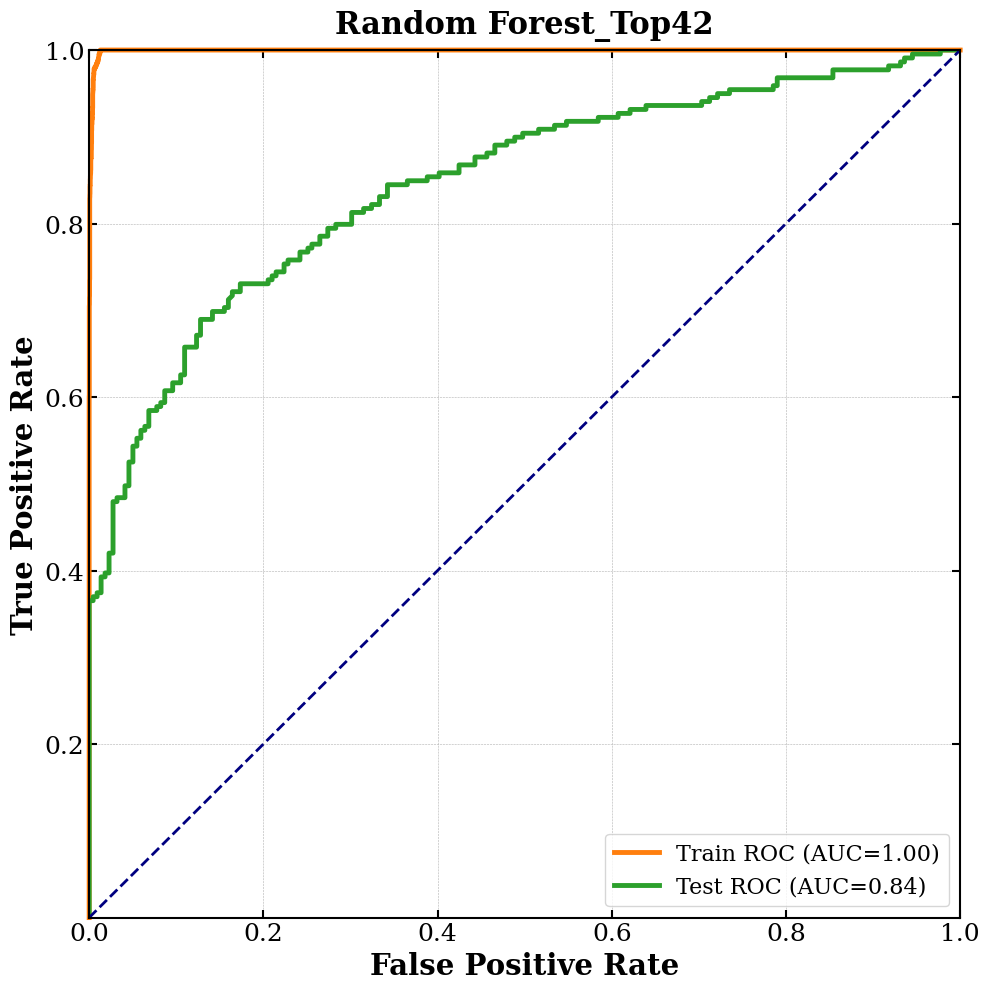


els for Top42:  20%|████████████████▌                                                                  | 1/5 [00:46<03:06, 46.56s/it]


[Model: SVM | Features: Top42] GridSearch Started
Fitting 5 folds for each of 12 candidates, totalling 60 fits


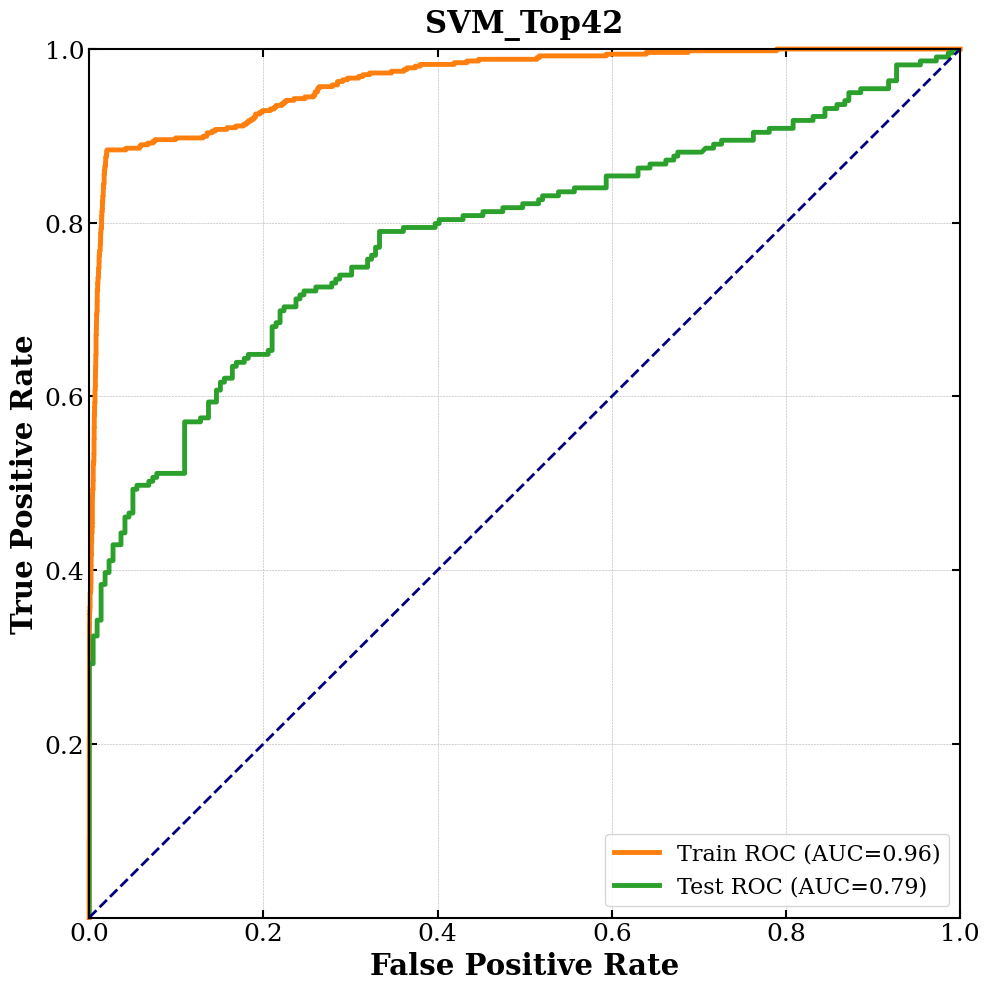


els for Top42:  40%|█████████████████████████████████▏                                                 | 2/5 [02:03<03:14, 64.68s/it]


[Model: XGBoost | Features: Top42] GridSearch Started
Fitting 5 folds for each of 64 candidates, totalling 320 fits


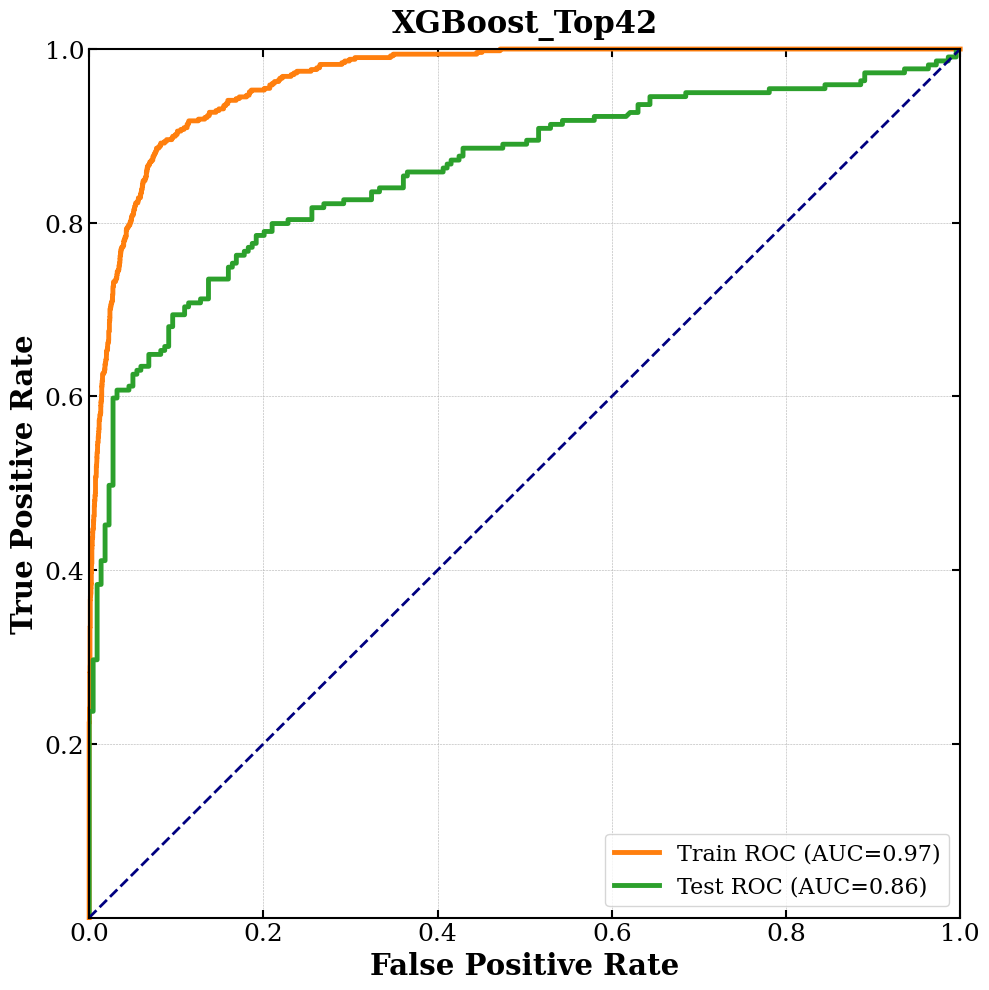


els for Top42:  60%|█████████████████████████████████████████████████▊                                 | 3/5 [02:15<01:20, 40.49s/it]


[Model: Logistic Regression | Features: Top42] GridSearch Started
Fitting 5 folds for each of 4 candidates, totalling 20 fits


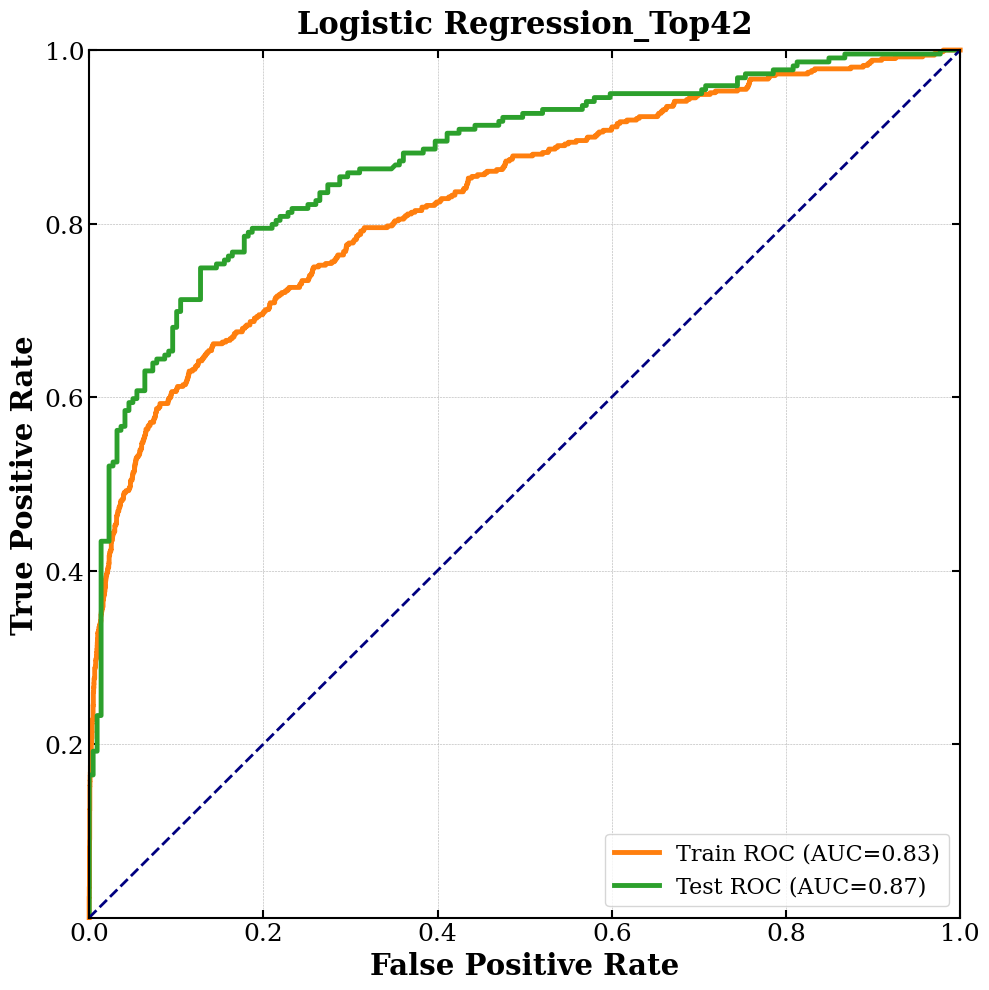


els for Top42:  80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [02:16<00:24, 24.78s/it]


[Model: MLP | Features: Top42] GridSearch Started
Fitting 5 folds for each of 192 candidates, totalling 960 fits


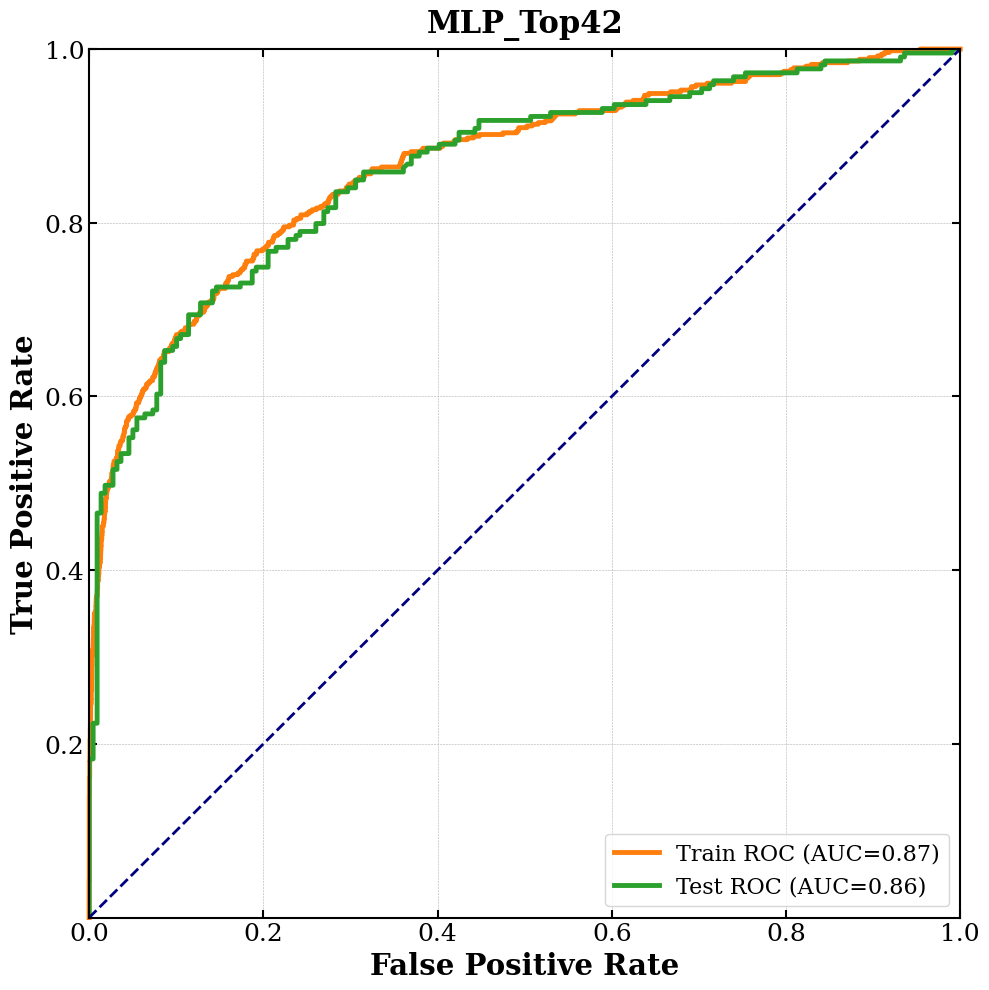


Feature Sets:  50%|███████████████████████████████████████████                                           | 1/2 [02:59<02:59, 179.13s/it]


=== Performance Summary for Feature Set: Top42 ===

=== Random Forest_Top42 ===
F1 Score:       Train=0.8546, CV=0.4512, Test=0.5000
AUC:            Train=0.9993, CV=0.8152, Test=0.8448
Accuracy:       Train=0.9813, CV=0.9409, Test=0.6667
MCC:            Train=0.8539, CV=0.4568, Test=0.4472
Specificity:    Train=0.9994, CV=0.9885, Test=1.0000
Best Params:    {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}

=== SVM_Top42 ===
F1 Score:       Train=0.6110, CV=0.4103, Test=0.5017
AUC:            Train=0.9646, CV=0.7615, Test=0.7865
Accuracy:       Train=0.9572, CV=0.9380, Test=0.6644
MCC:            Train=0.6291, CV=0.4198, Test=0.4341
Specificity:    Train=0.9963, CV=0.9884, Test=0.9909
Best Params:    {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

=== XGBoost_Top42 ===
F1 Score:       Train=0.5873, CV=0.4811, Test=0.5316
AUC:            Train=0.9658, CV=0.8286, Test=0.8577
Accuracy:       Tra


els for Top72:   0%|                                                                                           | 0/5 [00:00<?, ?it/s]


[Model: Random Forest | Features: Top72] GridSearch Started
Fitting 5 folds for each of 36 candidates, totalling 180 fits


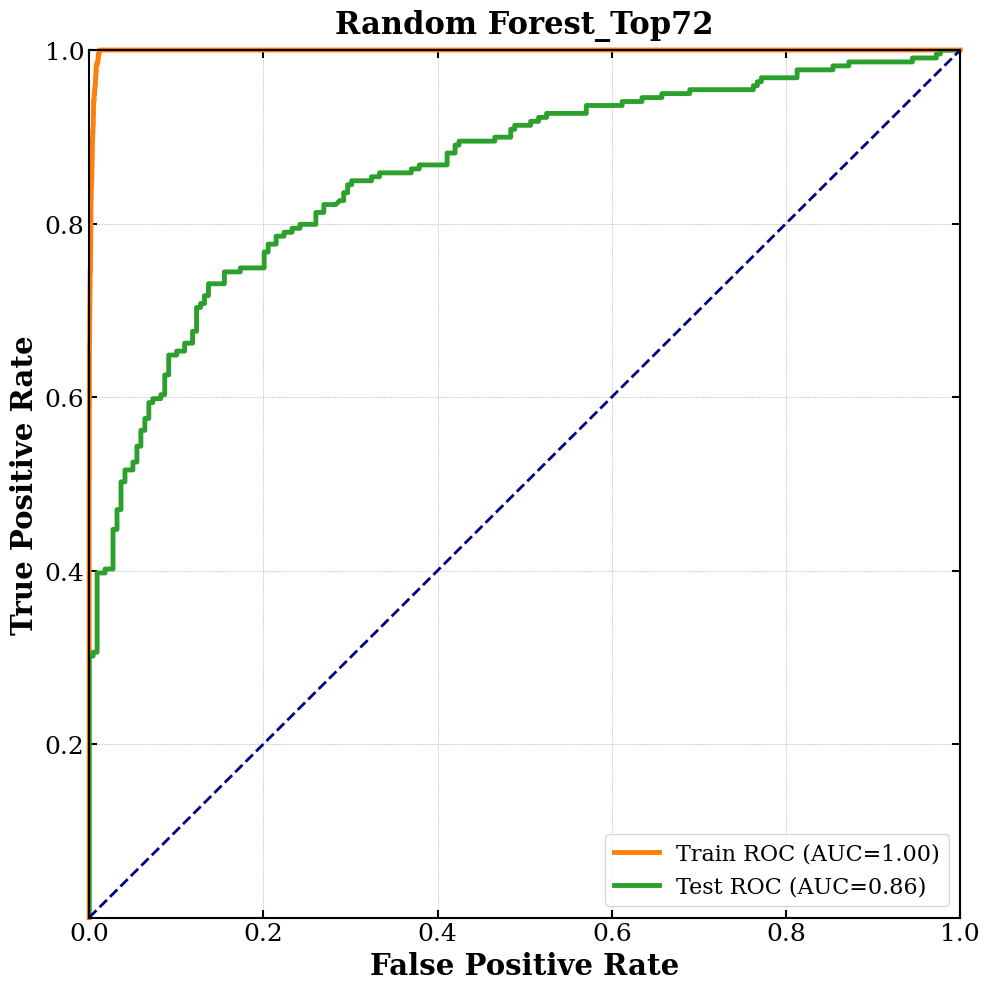


els for Top72:  20%|████████████████▌                                                                  | 1/5 [01:11<04:46, 71.52s/it]


[Model: SVM | Features: Top72] GridSearch Started
Fitting 5 folds for each of 12 candidates, totalling 60 fits


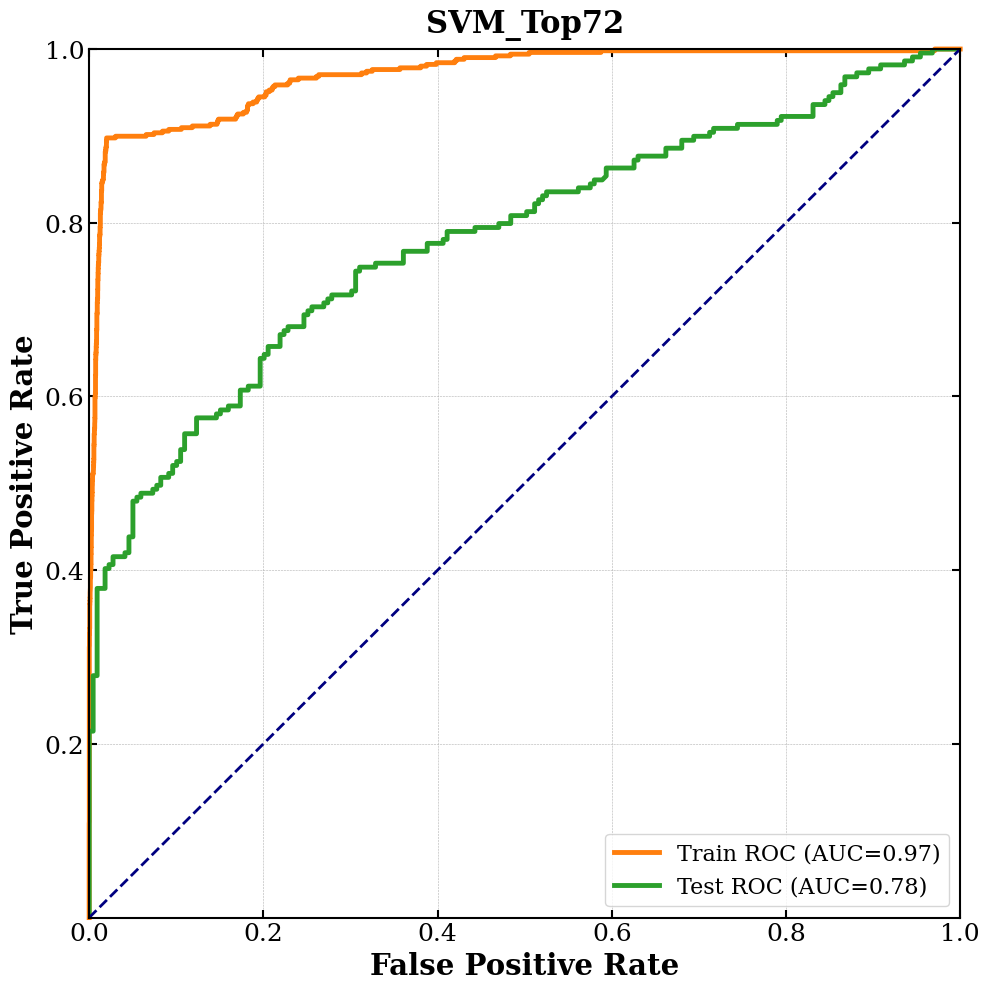


els for Top72:  40%|█████████████████████████████████▏                                                 | 2/5 [02:20<03:29, 69.76s/it]


[Model: XGBoost | Features: Top72] GridSearch Started
Fitting 5 folds for each of 64 candidates, totalling 320 fits


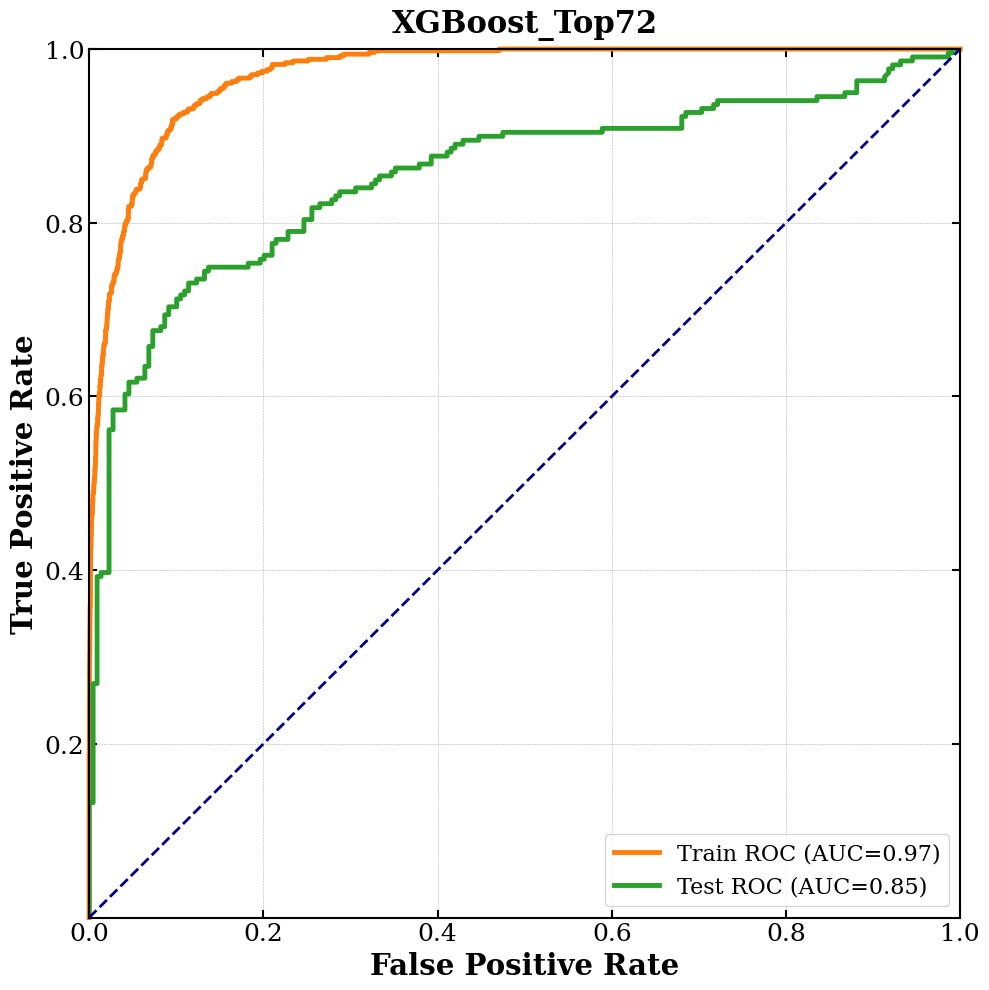


els for Top72:  60%|█████████████████████████████████████████████████▊                                 | 3/5 [02:41<01:35, 47.86s/it]


[Model: Logistic Regression | Features: Top72] GridSearch Started
Fitting 5 folds for each of 4 candidates, totalling 20 fits


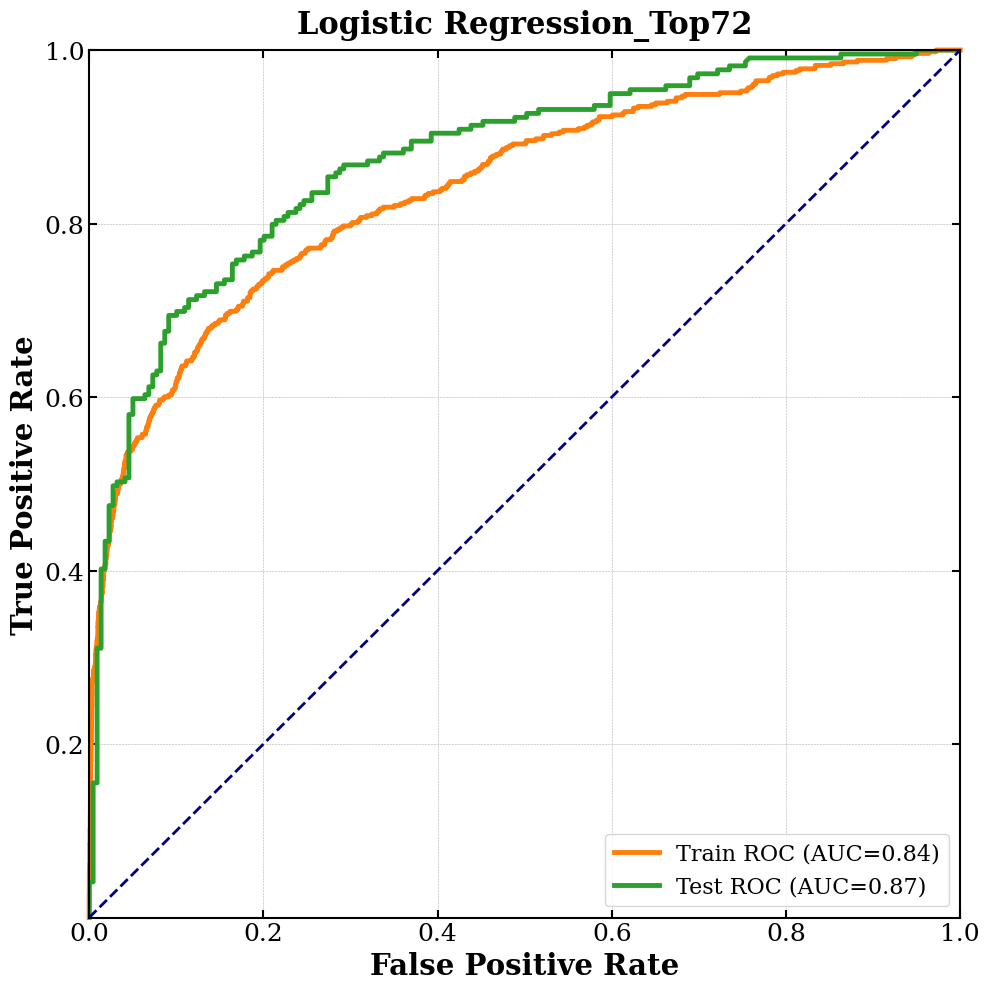


els for Top72:  80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [02:47<00:31, 31.10s/it]


[Model: MLP | Features: Top72] GridSearch Started
Fitting 5 folds for each of 192 candidates, totalling 960 fits


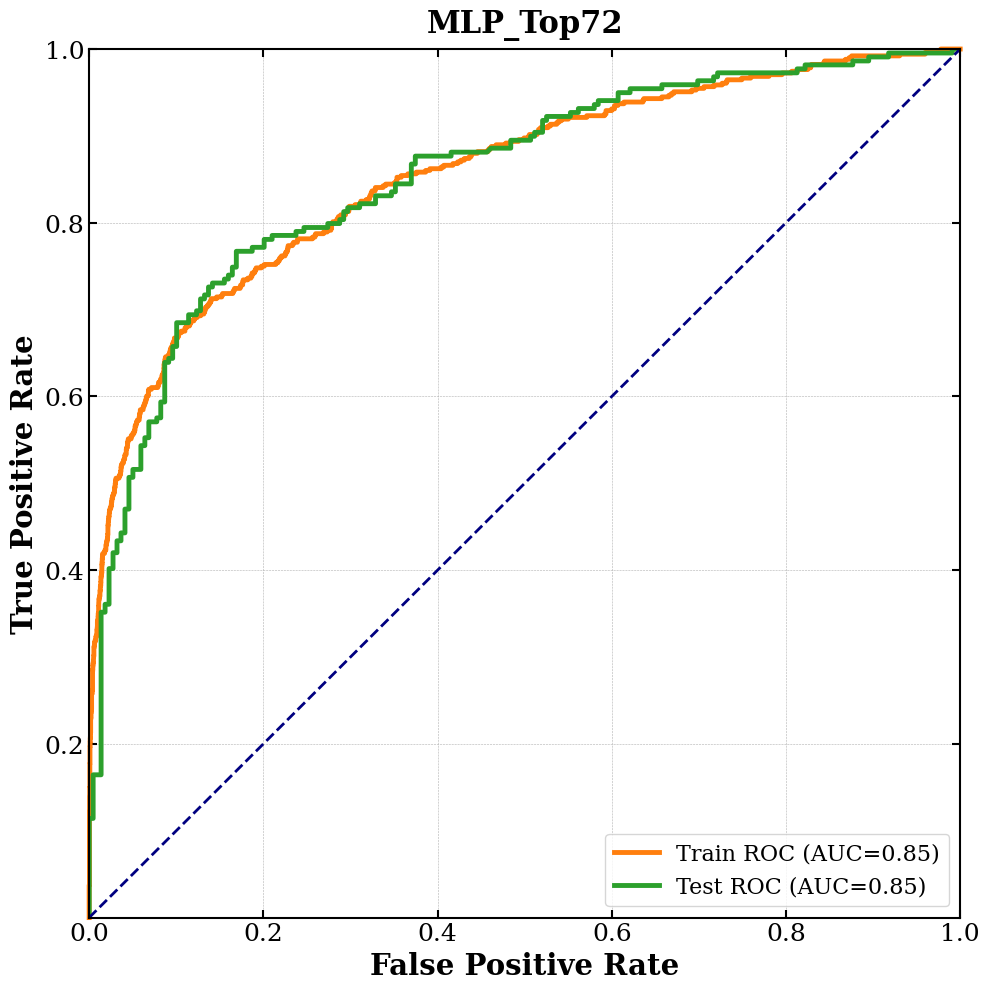


Feature Sets: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:36<00:00, 198.18s/it]


=== Performance Summary for Feature Set: Top72 ===

=== Random Forest_Top72 ===
F1 Score:       Train=0.7934, CV=0.4545, Test=0.4863
AUC:            Train=0.9989, CV=0.8214, Test=0.8583
Accuracy:       Train=0.9749, CV=0.9433, Test=0.6575
MCC:            Train=0.7987, CV=0.4738, Test=0.4227
Specificity:    Train=0.9995, CV=0.9919, Test=0.9909
Best Params:    {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

=== SVM_Top72 ===
F1 Score:       Train=0.6103, CV=0.4220, Test=0.5118
AUC:            Train=0.9697, CV=0.7673, Test=0.7822
Accuracy:       Train=0.9577, CV=0.9397, Test=0.6689
MCC:            Train=0.6330, CV=0.4353, Test=0.4416
Specificity:    Train=0.9972, CV=0.9896, Test=0.9909
Best Params:    {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

=== XGBoost_Top72 ===
F1 Score:       Train=0.6142, CV=0.4873, Test=0.4915
AUC:            Train=0.9711, CV=0.8314, Test=0.8547
Accuracy:       Train=

In [12]:
# Iterate through each feature subset (Top51, Top79)
for feature_name, col_list in tqdm(feature_sets.items(), desc="Feature Sets", total=len(feature_sets)):
    print(f"\n=== Feature Set: {feature_name} ===")
    
    # Extract selected features for training and testing
    X_train_df = train_cls[col_list]
    X_test_df = test_cls[col_list]

    # Loop over each model and perform GridSearchCV
    for model_name, pipeline, param_grid in tqdm(models, desc=f"Models for {feature_name}", total=len(models)):
        print(f"\n[Model: {model_name} | Features: {feature_name}] GridSearch Started")

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=skfold,
            scoring=scoring,
            refit='f1',
            n_jobs=16,
            verbose=1
        )

        # Fit on training data
        grid_search.fit(X_train_df, Y_train_cls)

        # Save best estimator
        best_estimators_dict[f'{model_name}_{feature_name}'] = grid_search.best_estimator_

        # Evaluate on train and test sets, plot ROC
        evaluate_model_no_smooth(
            grid_search,
            f'{model_name}_{feature_name}',
            X_train_df, Y_train_cls,
            X_test_df, Y_test_cls,
            figure_path
        )

    # Print performance summary for this feature subset
    print(f"\n=== Performance Summary for Feature Set: {feature_name} ===")
    for model_key, scores in performance_scores.items():
        if feature_name in model_key:
            print(f"\n=== {model_key} ===")
            print(f"F1 Score:       Train={scores['Train F1']:.4f}, CV={scores['CV F1']:.4f}, Test={scores['Test F1']:.4f}")
            print(f"AUC:            Train={scores['Train AUC']:.4f}, CV={scores['CV AUC']:.4f}, Test={scores['Test AUC']:.4f}")
            print(f"Accuracy:       Train={scores['Train Accuracy']:.4f}, CV={scores['CV Accuracy']:.4f}, Test={scores['Test Accuracy']:.4f}")
            print(f"MCC:            Train={scores['Train MCC']:.4f}, CV={scores['CV MCC']:.4f}, Test={scores['Test MCC']:.4f}")
            print(f"Specificity:    Train={scores['Train Specificity']:.4f}, CV={scores['CV Specificity']:.4f}, Test={scores['Test Specificity']:.4f}")
            print(f"Best Params:    {best_params[model_key]}")

# Select the final model based on highest Test F1 score
best_model_name = None
best_test_f1 = 0.0
for model_key, scores in performance_scores.items():
    if scores['Test F1'] > best_test_f1:
        best_test_f1 = scores['Test F1']
        best_model_name = model_key

print(f"\nFinal selected model: {best_model_name} (Test F1 = {best_test_f1:.4f})")

# Display all best estimators
for name, est in best_estimators_dict.items():
    print(f"Best Estimator: {name} -> {est}")

# Save performance results to CSV
performance_df = pd.DataFrame.from_dict(performance_scores, orient='index')
performance_df = performance_df.round(4)
performance_df.to_csv("performance_scores_with_rawdata.csv", index=True)

# Save best hyperparameters to CSV
params_df = pd.DataFrame.from_dict(best_params, orient='index')
params_df.to_csv("best_hyperparameters_with_rawdata.csv", index=True)

#### **Comparative Test set performance without resampled strategy**

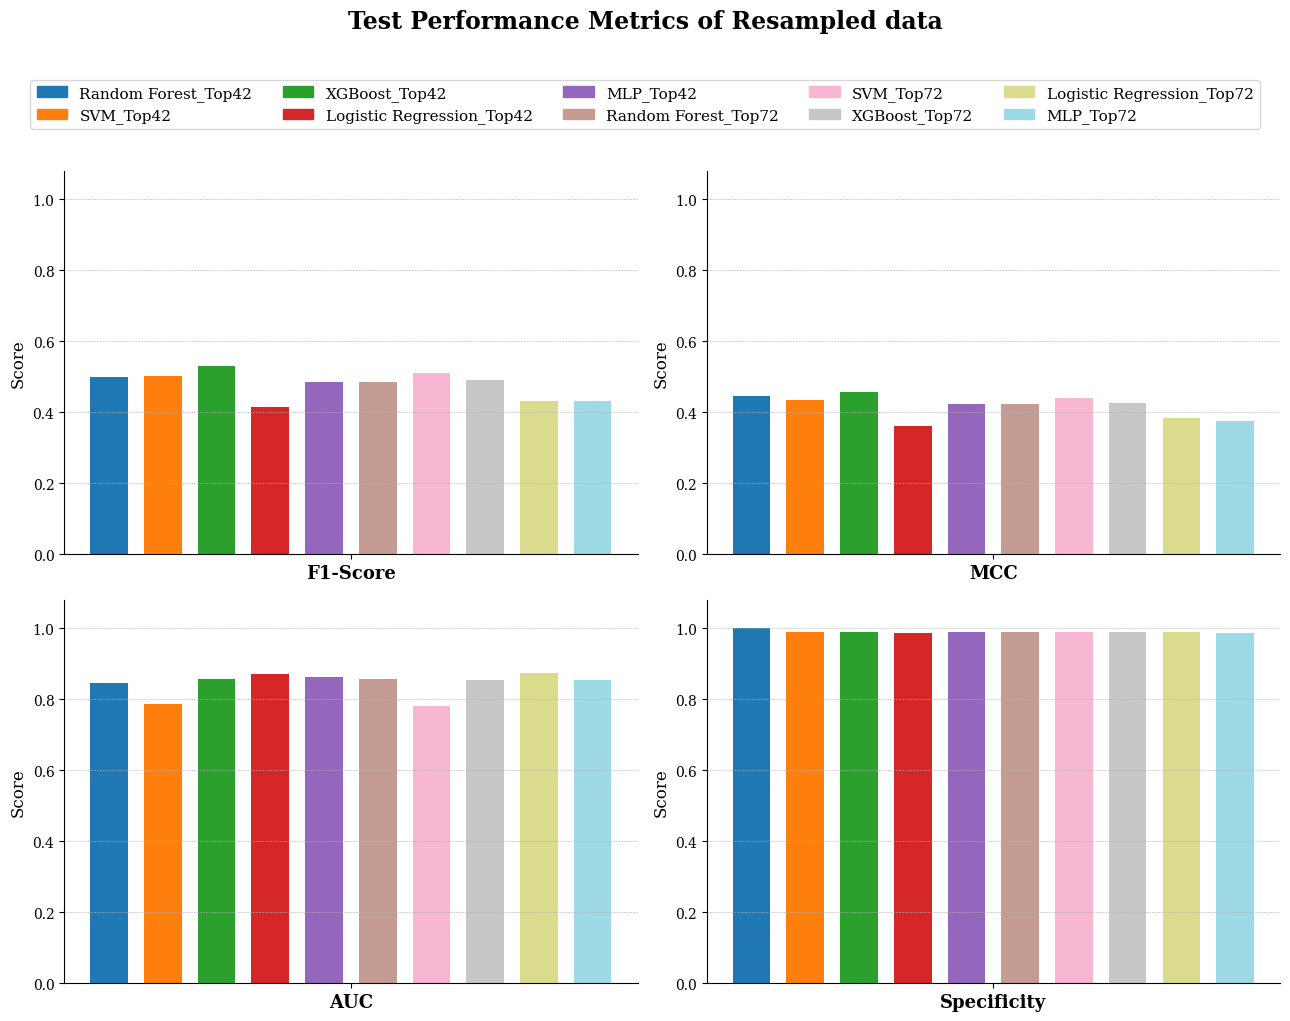

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Metric (label for DataFrame column, display name)
metric_labels = [
    ("Test F1", "F1-Score"),
    ("Test MCC", "MCC"),
    ("Test AUC", "AUC"),
    ("Test Specificity", "Specificity")
]

model_names = performance_df.index.tolist()
n_models = len(model_names)

# Assign distinct colors to each model
colors = plt.cm.tab20(np.linspace(0, 1, n_models))
color_dict = dict(zip(model_names, colors))

fig, axs = plt.subplots(2, 2, figsize=(13, 9))
bar_width = 0.7

for idx, (metric_key, metric_display) in enumerate(metric_labels):
    row = idx // 2
    col = idx % 2
    ax = axs[row, col]

    # Retrieve metric scores in the order of model_names
    metric_series = performance_df.loc[model_names, metric_key]
    scores = metric_series.values
    color_seq = [color_dict[m] for m in model_names]

    # X-axis: model indices
    x = np.arange(1)
    for i in range(n_models):
        ax.bar(i, scores[i], width=bar_width, color=color_seq[i])

    ax.set_xticks([(n_models - 1) / 2])
    ax.set_xticklabels([metric_display], fontsize=13, fontweight='bold')
    
    ax.set_ylim(0, 1.08)
    ax.set_ylabel("Score", fontsize=12)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.4)


    # Remove top/right border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add legend
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(n_models)]
fig.legend(handles, model_names, loc='upper center', ncol=5, fontsize=11, bbox_to_anchor=(0.5, 1.06))

plt.suptitle("Test Performance Metrics of Resampled data", fontsize=17, fontweight='bold', y=1.13)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.subplots_adjust(top=0.95)

# Save to ./figure_total_neg/
save_path = os.path.join("figure_total_neg", "Test performance metrics of non-resampled data.jpg")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()